# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.22.2.post1'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [90]:
#http://www.adeveloperdiary.com/data-science/computer-vision/applying-gaussian-smoothing-to-an-image-using-python-from-scratch/#:~:text=%20Applying%20Gaussian%20Smoothing%20to%20an%20Image%20using,%206%20Project%20in%20Github%3A.%20%20More%20
def GaussianBlur(image, kernal_size, reshape=False):

    #https://en.wikipedia.org/wiki/Gaussian_blur
    GaussianFunction_2D = lambda x,y,s: (1 / (2 * np.pi * s)) * (np.exp (-((x**2 + y**2) / (2*(s**2)))))

    # Using the Guassian function we create a n x n matrix to use over each pixel in the image
    blur = np.array([float(i) for i in range(-((kernal_size - 1) // 2), (kernal_size + 1) // 2)])
    for i in range(kernal_size):
        blur[i] = GaussianFunction_2D(blur[i], 0, np.sqrt(kernal_size))
    blur = np.outer(blur.T, blur.T) / np.outer(blur.T, blur.T).max()

    size = int(np.sqrt(image.shape))
    img = image.reshape(size,size)

    # A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
    # Decided to just put the padding logic together since its easy to look up
    # padding accounts for edge case of image
    l = int((kernal_size - 1) / 2)
    padded_image = np.zeros((size + (2 * l), size + (2 * l)))
    padded_image[l:padded_image.shape[0] - l, l:padded_image.shape[1] - l] = img
    #img = np.pad(img, pad_width=int(2*(kernal_size/3)), mode='constant', constant_values=0)

    # apply the blur to the padded image
    output = np.zeros(img.shape)
    for r in range(size):
        for c in range(size):
            output[r, c] = np.sum(blur * padded_image[r:r + kernal_size, c:c + kernal_size]) 
    
    if reshape:
      return (output, blur) # reshape the image for display
    else:
      return (output.reshape(image.shape,), blur) # keep the image in as single array  
 

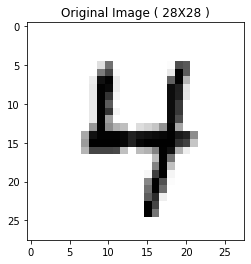

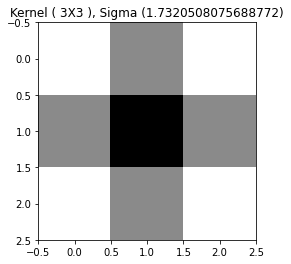

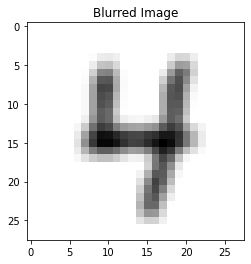

In [91]:
# Test Blur function
img = X[1] # grab first image from 
size = 3 # pick a kernel size to blur on, 3 will show 8 neighbour result as requested

blur_img, kernel = GaussianBlur(img, size, True)
sigma = np.sqrt(size)

# Orignial image untouched
plt.imshow(img.reshape(28,28), cmap='gray_r')
plt.title("Original Image ( {}X{} )".format(28,28))
plt.show()

# what the blur gradiant looks like
plt.imshow(kernel, interpolation='none', cmap='gray_r')
plt.title("Kernel ( {}X{} ), Sigma ({})".format(size, size, sigma))
plt.show()

# what the blur kernal applied results
plt.imshow(blur_img, cmap='gray_r')
plt.title("Blurred Image")
plt.show()


In [93]:
# blur function to build, time measure, and compare scores
def blur(kernel):
  # 1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
  print(f'\n\x1b[1m Gaussian Blur with Kernal size of {kernel} \n\x1b[1m')

  # Lambda Blur for full data sets
  blur = lambda img: [GaussianBlur(i, kernel)[0] for i in img]

  # 2. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  #     Do not use the filter
  #     Filter the training data but not the dev data
  #     Filter the dev data but not the training data
  #     Filter both training data and dev data

  # Blur dev_data
  start = time.time()
  dev_data_blur = blur(dev_data) # Evaluate performance on the (filtered) dev set.
  print(f'Blurring dev_data time was {time.time() - start} sec(s)')

  # Blur mini_train_data
  start = time.time()
  mini_train_data_blur = blur(mini_train_data) # Train on the (filtered) mini train set.
  print(f'Blurring mini_train_data time was {time.time() - start} sec(s)')

  print(f'KNN (mini_train_data), UnBlurred dev_data set score: {knn_unblurred.score(dev_data, dev_labels)}')
  print(f'KNN (mini_train_data),   Blurred dev_data set score: {knn_unblurred.score(dev_data_blur, dev_labels)}')

  knn_blurred = KNeighborsClassifier(1)
  knn_blurred.fit(mini_train_data_blur, mini_train_labels)
  print(f'KNN (mini_train_data_blur), UnBlurred dev_data set score: {knn_blurred.score(dev_data, dev_labels)}')
  print(f'KNN (mini_train_data_blur),   Blurred dev_data set score: {knn_blurred.score(dev_data_blur, dev_labels)}')



In [94]:
def Q1():
    
  ### STUDENT START ###
  
  # 3. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
  for k in [3,5,7,9]: # k = 3 is 8 neighbour blur, and we compare increasing blur to value of accuracy with the classifier as we increase blur
    # 4. Experiment with weights that makes one model's accuracy at least 0.9.
    #     Kernal size of 3 with blur both mini train data and dev data sets get's
    blur(k) 
     
  ### STUDENT END ###

Q1()


 Gaussian Blur with Kernal size of 3 

Blurring dev_data time was 7.067971706390381 sec(s)
Blurring mini_train_data time was 7.119569778442383 sec(s)
KNN (mini_train_data), UnBlurred dev_data set score: 0.884
KNN (mini_train_data),   Blurred dev_data set score: 0.686
KNN (mini_train_data_blur), UnBlurred dev_data set score: 0.168
KNN (mini_train_data_blur),   Blurred dev_data set score: 0.903

 Gaussian Blur with Kernal size of 5 

Blurring dev_data time was 6.913800477981567 sec(s)
Blurring mini_train_data time was 6.550451278686523 sec(s)
KNN (mini_train_data), UnBlurred dev_data set score: 0.884
KNN (mini_train_data),   Blurred dev_data set score: 0.441
KNN (mini_train_data_blur), UnBlurred dev_data set score: 0.166
KNN (mini_train_data_blur),   Blurred dev_data set score: 0.897

 Gaussian Blur with Kernal size of 7 

Blurring dev_data time was 6.752645254135132 sec(s)
Blurring mini_train_data time was 6.682894706726074 sec(s)
KNN (mini_train_data), UnBlurred dev_data set score: 0.

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [95]:
# Solution with binarization by explicit binarize function

def Q2():

### STUDENT START ###
  # 1.1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use BernoulliNB's binarize parameter to set the white/black separation threshold to 0.1. Use BernoulliNB to produce the model.
  bnb = BernoulliNB(binarize=0.1)
  bnb.fit(mini_train_data, mini_train_labels)

  # 1.2. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9. Here you'll likely need to implement a trianarize helper function. Since we are going beyond the binary representation of our features, you should use MultinomialNB to produce the model.
  # Lambda function to categorize pixels to white{0}/grey{1}/black{2} as a threshold between 0.1 and 0.9
  trianarize = lambda vectors: [[0 if v <= 0.1 else 1 if v <= 0.9 else 2 for v in vector] for vector in vectors]

  mnb = MultinomialNB()
  trainset = trianarize(mini_train_data)
  mnb.fit(trainset, mini_train_labels)
  testset = trianarize(dev_data)

  # 2. Show the Bernoulli model accuracy and the Multinomial model accuracy.
  print(f'BernoulliNB score: {bnb.score(dev_data, dev_labels)}')
  print(f'MultinomialNB score: {mnb.score(testset, dev_labels)}')
  
  # 3. Does the multinomial version improve the results? Why or why not?
  print(f'The Multinomial model version does not improve the results as compared to the binariazed Bernoulli NB model.')

### STUDENT END ###

Q2()

BernoulliNB score: 0.814
MultinomialNB score: 0.807
The Multinomial model version does not improve the results as compared to the binariazed Bernoulli NB model.


ANSWER: The Multinomial model version does not improve the results as compared to the binariazed Bernoulli NB model. 

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [155]:
def Q3(alphas):

### STUDENT START ###
  # 1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance. Show the accuracy at each alpha value.
  print("\n\x1b[1m 1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance. \n Show the accuracy at each alpha value. \n\x1b[1m ")
  values = {}
  for a in alphas['alpha']:
    bnb = BernoulliNB(alpha=a) # binarize - float or None, default=0.0
    bnb.fit(mini_train_data, mini_train_labels)        
    s = bnb.score(dev_data, dev_labels) # cv_results_ need to sw
    values[a] = s    

  # Show the accuracy of values

  print("Show the accuracy of values without cross-validation")
  {print(f'   score: {s}, alpha: {a}') for a, s in values.items()}

  # Create the required validator and fit it
  GS = GridSearchCV(BernoulliNB(), alphas, cv=5, scoring='accuracy', iid=False)
  GS.fit(mini_train_data, mini_train_labels)

  # 2. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?
  print("\n\x1b[1m What is the best value for alpha?  \n\x1b[1m")
  # compare score to last score to find best value
  #bestvalue = GS.cv_results_
  df = pd.DataFrame(GS.cv_results_)    
  print("Show the accuracy of values with cross-validation")
  {print(f'   score: {round(s,4)}, alpha: {a}') for a, s in zip(df['param_alpha'], df['mean_test_score'])}
  r = df.loc[(df.rank_test_score == 1), ['param_alpha', 'mean_test_score']]
  a,s = tuple(r.itertuples(index=False, name=None))[0]
  print(f'score: {s}, alpha: {a}')

  print("\n\x1b[1m What is the accuracy when alpha is near 0?  \n\x1b[1m")
  minvalue = min(values)
  print(f'score: {values[minvalue]}, alpha: {minvalue}')

  print("\n\x1b[1m Is this what you'd expect? \n\x1b[1m")
  print("     Yes, smoothing keeps the count and address's the zero values in the probablity")

  return GS;

### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)



 1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance. 
 Show the accuracy at each alpha value. 
 
Show the accuracy of values without cross-validation
   score: 0.816, alpha: 1e-10
   score: 0.823, alpha: 0.0001
   score: 0.823, alpha: 0.001
   score: 0.824, alpha: 0.01
   score: 0.822, alpha: 0.1
   score: 0.816, alpha: 0.5
   score: 0.809, alpha: 1.0
   score: 0.811, alpha: 2.0
   score: 0.779, alpha: 10.0

 What is the best value for alpha?  

Show the accuracy of values with cross-validation
   score: 0.814, alpha: 1e-10
   score: 0.819, alpha: 0.0001
   score: 0.825, alpha: 0.001
   score: 0.822, alpha: 0.01
   score: 0.818, alpha: 0.1
   score: 0.813, alpha: 0.5
   score: 0.809, alpha: 1.0
   score: 0.805, alpha: 2.0
   score: 0.783, alpha: 10.0
score: 0.825, alpha: 0.001

 What is the accuracy when alpha is near 0?  

score: 0.816, alpha: 1e-10

 Is this what you'd expect? 

     Yes, smoot

GridSearchCV(cv=5, error_score=nan,
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid=False, n_jobs=None,
             param_grid={'alpha': [1e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0,
                                   2.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

ANSWER: Is this what you'd expect? 

     Yes, smoothing keeps the count and address's the zero values in the probablity

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [100]:
def Q4():

  ### STUDENT END ### 
  # 1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well.
  print("\n\x1b[1m 1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. \x1b[1m")
  gnb = GaussianNB()
  gnb.fit(mini_train_data, mini_train_labels) # Train on the mini train set.
  perf = gnb.score(dev_data, dev_labels) # Evaluate performance on the dev set.
  print(f'GaussianNB scores {perf}') 

  # 2. Diagnose and explain the problem.
  print("\n\x1b[1m 2. Diagnose and explain the problem. \x1b[1m")
  print("\n\x1b[1m 2. In the training data there is a-typical samples that drastically deviate from the normal for samples. This create alot of noise! \x1b[1m")

  # 3. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model.
  print("\n\x1b[1m 3. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. \x1b[1m")
  smooth_gnb = GaussianNB(var_smoothing=.0592) # Take a look at var_smoothing argument for GaussianNB. (lower bound = 0.0592, upper bound = 0.0614, for the maximal improvment of the score)
  smooth_gnb.fit(mini_train_data, mini_train_labels)
  print(f'Using var_smoothing argument for GaussianNB. (lower bound = 0.0592, upper bound = 0.0614, for the maximal improvment of the score)') 
  
  # 4. Show the model accuracy before your fix and the model accuracy after your fix.
  print("\n\x1b[1m 4. Show the model accuracy before your fix and the model accuracy after your fix. \x1b[1m")
  print(f'GaussianNB scores {smooth_gnb.score(dev_data, dev_labels)}, with var_smoothing')
  
  # 5. Explain your solution.
  print("\n\x1b[1m 5. Explain your solution. \x1b[1m")   
  print("Classification Report: Standard Gaussian Naive Bayes")
  print(classification_report(gnb.predict(dev_data), dev_labels))
  print("Classification Report: Smooth Gaussian Naive Bayes")
  print(classification_report(smooth_gnb.predict(dev_data), dev_labels))
  print("\n We can see the imporvement in the accuracy from the stanard GNB to the varation smoothed GNB model")
  ### STUDENT END ###

Q4()


 1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
GaussianNB scores 0.593

 2. Diagnose and explain the problem. 

 2. In the training data there is a-typical samples that drastically deviate from the normal for samples. This create alot of noise! 

 3. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
Using var_smoothing argument for GaussianNB. (lower bound = 0.0592, upper bound = 0.0614, for the maximal improvment of the score)

 4. Show the model accuracy before your fix and the model accuracy after your fix. 
GaussianNB scores 0.821, with var_smoothing

 5. Explain your solution. 
Classification Report: Standard Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       124
           1       0.81      0.87      0.84       110
           2       0

ANSWER: In the training data there is a-typical samples that drastically deviate from the normal for samples. This create alot of noise!

We can see the imporvement in the accuracy from the stanard GNB to the varation smoothed GNB model

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



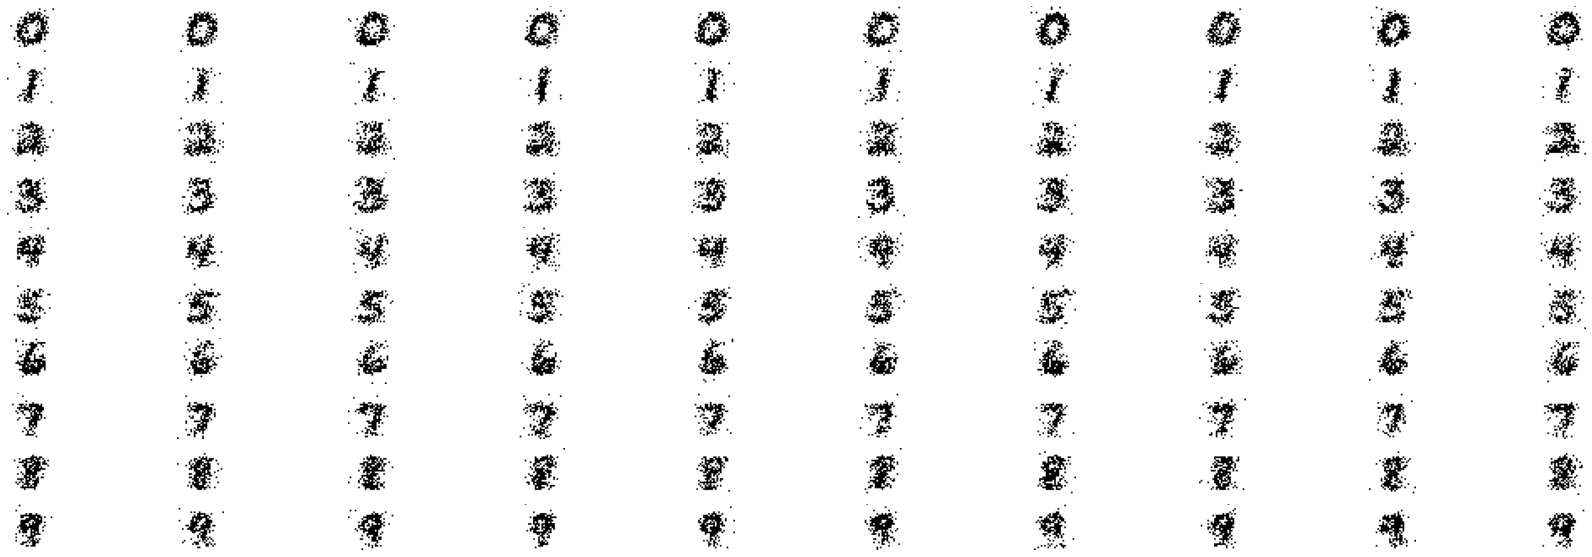

In [99]:
def Q5(num_examples):

  ### STUDENT START ###

  # 1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. 
  #    Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1. 
  #    Show the grid.
  bnb = BernoulliNB()
  bnb.fit(mini_train_data, mini_train_labels)

  figure = plt.figure(figsize=(30, 10))
  
  # You can use np.random.rand() to generate random numbers from a uniform distribution.   
  # The estimated probability of each pixel being 0 or 1 is stored in the model's feature_log_prob_ attribute. 
  # You can use np.exp() to convert a log probability back to a probability.
  glyphs = lambda idx,n: [j for j in np.transpose([v > np.random.rand(n) for v in np.exp(bnb.feature_log_prob_)[idx]])];

  i = 0
  for j in range(10):      
      for glyph in glyphs(j, num_examples):
          axes = figure.add_subplot(num_examples, 10, i+1) # add to subplot in figure
          axes.set_axis_off() # clean view
          axes.imshow(glyph.reshape(28,28), cmap='gray_r') # show k generated result
          i += 1 # Move the figure subplot forward one

  # 2. How do the generated digit images compare to the training digit images?
  #     The generated digits are dithered but not to far off from the originals as a human see's it anyway. 
  #     You can see the dithering is a result of randomly selecting the pixels and the probabilities are not perfect.

  ### STUDENT END ###

Q5(10)

How do the generated digit images compare to the training digit images?

ANSWER: 
The generated digits are dithered but not to far off frmo the originals as a human see's it anyway. You can see the dithering is a result of randomly selecting the pixels and the probabilities are not perfect. 

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.




 1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance. 
 Show the accuracy at each alpha value. 
 
   score: 0.816, alpha: 1e-10
   score: 0.823, alpha: 0.0001
   score: 0.823, alpha: 0.001
   score: 0.824, alpha: 0.01
   score: 0.822, alpha: 0.1
   score: 0.816, alpha: 0.5
   score: 0.809, alpha: 1.0
   score: 0.811, alpha: 2.0
   score: 0.779, alpha: 10.0


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 What is the best value for alpha?  

score: 0.824, alpha: 0.01

 What is the accuracy when alpha is near 0?  

score: 0.816, alpha: 1e-10

 Is this what you'd expect? 

Using alpha = 0.001
Total count of Buckets: [0, 31, 67, 59, 46, 62, 33, 43, 659]
Count of Correct Buckets:  [0, 11, 29, 27, 30, 48, 26, 34, 618]


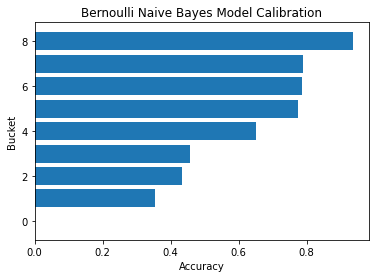

In [113]:
def Q6(buckets, correct, total):
    
  ### STUDENT START ###

  alpha = Q3(alphas).best_params_['alpha']
  print(f'Using alpha = {alpha}')

  # 1. Produce a Bernoulli Naive Bayes model.
  bnb = BernoulliNB(alpha=alpha)
  bnb.fit(mini_train_data, mini_train_labels) 

  # 2. Evaluate performance:
  #   1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
  #       Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
  #       Then estimate the actual accuracy the classifier achieved for each bucket.
  #       So, for each prediction:
  #         Find the bucket whose range includes the estimated posterior probability,
  #         and update "correct" and "total" counters accordingly.
  for posterior, label in zip(bnb.predict_proba(dev_data), dev_labels):
    bucket = [idx for idx, value in enumerate(buckets) if value >= max(posterior)][0] # enumerate the buckets for max posterior probability to find its index
    total[bucket] += 1 # count total by index    
    correct[bucket] += 1 if str(list(posterior).index(max(posterior))) == label else 0 # count correct by index

  #         Show the accuracy for each bucket.
  print("Total count of Buckets:", total)
  print("Count of Correct Buckets: ", correct)

  # 3. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?
  #     The accuracy decreases
  accuracy = [correct[idx]/t if t != 0 else 0 for idx, t in enumerate(total)]
  plt.barh(range(len(accuracy)), accuracy)
  plt.xlabel('Accuracy')
  plt.ylabel('Bucket')
  plt.title('Bernoulli Naive Bayes Model Calibration')

  ### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

ANSWER: The Accuracy increases with the increase of bucket count

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [123]:
def Q7():

  ### STUDENT START ###
  # 1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
  # np.concatenate([X[1].copy(), np.sum(X[1].reshape(28,28), axis = 0), np.sum(X[1].reshape(28,28), axis = 1)])
  FeatureAdd = lambda i: np.concatenate([i.copy(), np.sum(i.reshape(28,28), axis = 0), np.sum(i.reshape(28,28), axis = 1)]) # Try summing or averaging the pixel values in each row & col.
  
  ext_mini_train = [FeatureAdd(m) for m in mini_train_data] # Train on the mini train set (enhanced to comprise the new features).
  ext_dev = [FeatureAdd(d) for d in dev_data] # Evaulate performance on the dev set.

  ext_bnb = BernoulliNB() 
  ext_bnb.fit(ext_mini_train, mini_train_labels) # Train on the mini train set (enhanced to comprise the new features).

  bnb = BernoulliNB()
  bnb.fit(mini_train_data, mini_train_labels) # Train on the mini train set

  # 2. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.
  print('Accuracy with added features:', ext_bnb.score(ext_dev, dev_labels))
  print('Accuracy without added features:',  bnb.score(dev_data, dev_labels)) # Evaulate performance on the dev set.

  ### STUDENT END ###

Q7()

Accuracy with added features: 0.816
Accuracy without added features: 0.809
